## Creating a Neural Network from scratch with Tensorflow Ops

I am doing this to practice working with data in Tensorflow. I will only use basic Tensorflow ops and structures. For example, I know that tf.nn.softmax will do the softmax computation for me, but I am implementing it myself.

In [28]:
import tensorflow as tf
from keras.datasets import mnist
# make sure tensorflow version >= 2.9.x for compatability
print(tf.__version__)
print(tf.config.experimental.list_physical_devices('GPU'))

import matplotlib.pyplot as plt
import time


2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset Creation

In [29]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [30]:
# since its going into a regular NN and not a CNN, we have to reshape it to 784
train_X = tf.reshape(train_X, (train_X.shape[0], 784))
test_X = tf.reshape(test_X, (test_X.shape[0], 784))

# normalize between 0 and 1
train_X = tf.divide(train_X, 255)
test_X = tf.divide(test_X, 255)

# change to floats
train_X = tf.cast(train_X, tf.float32)
test_X = tf.cast(test_X, tf.float32)
train_y = tf.cast(train_y, tf.float32)
test_y = tf.cast(test_y, tf.float32)

# now create dataset
train_set = tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(32)
print(train_set.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [31]:
# analyze some data
image_size = tf.constant(train_X[0].numpy().size, dtype=tf.float16)
image_side_length = tf.cast(tf.sqrt(image_size), tf.int32)
print(f"MNIST images have size {image_size.numpy()}, {image_side_length}x{image_side_length}")

MNIST images have size 784.0, 28x28


## Network Creation

In [32]:
def ReLU(x):
    return tf.math.maximum(tf.constant(0, dtype=tf.float32), x)

# derivative of the ReLU for backprop
def dReLU(x):
    x = x.numpy() # convert to np arr for list indexing
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softmax(z):
    # for stability
    e_z = tf.exp(tf.subtract(z, tf.math.reduce_max(z)))
    return e_z / tf.reduce_sum(e_z) 

In [33]:
# cross entropy loss is the more general form of the binary classification formula
def cross_entropy_loss(actual, pred): # both (batch_size, 10)
    eps = 0.0001

    # pred and actual are probablilty distributions for the 10 classes
    # e.g. [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] for the actual
    # maybe [.73, .2302, ...] for pred
    loss = -tf.math.reduce_sum(tf.math.multiply(actual, tf.math.log(tf.add(pred, eps))))

    # normalize by number of samples
    return tf.math.subtract(loss, actual.numpy().shape[0])

Remember, the formula to compute the delta for a layer l is 
$$\delta^l = ((w^{l+1})^T\delta^{l+1}) * dg^l(z^l)$$

In [34]:
import numpy as np

In [35]:
class FCLayer(tf.keras.layers.Layer):
    def __init__(self, num_neurons, eps=.1):
        super(FCLayer, self).__init__()
        self.num_neurons = num_neurons
        self.eps = eps
        self.z = None
        self.a = None
        self.delta = None

    def build(self, input_shape):
        # shapes are usually ordered like this:
        # (batch_size, width, height, features)
        num_inputs = input_shape[-1]
        self.w = tf.random.uniform((num_inputs, self.num_neurons), minval=-self.eps, maxval=self.eps, dtype=tf.float32)
        self.b = tf.random.uniform((1, self.num_neurons), minval=-self.eps, maxval=self.eps, dtype=tf.float32)
        
    def call(self, inputs):
        return tf.add(tf.matmul(inputs, self.w), self.b)

class DenseNeuralNet(tf.keras.Model):
    def __init__(self, layer_neurons, learning_rate=.001, regularization_rate=0.1):
        super().__init__()

        self.learning_rate = learning_rate
        self.regularization_rate = regularization_rate
        self.loss_history = []
        
        # setup layers
        self._layers = []
        for i in range(len(layer_neurons)):
            num_neurons_in_layer = layer_neurons[i]
            self._layers.append(FCLayer(num_neurons_in_layer))
        
        softmax_clf = FCLayer(10)
        self._layers.append(softmax_clf)
        
    
    def train_step(self, data):
        x, y = data
        # feed forward
        y_pred = self(x) # (batch_size, 10)

        y = tf.one_hot(tf.cast(y, tf.int32), 10)
        
        # back prop
        for i in range(len(self._layers)-1, 0, -1):
            layer = self._layers[i]
            prev_a = self._layers[i-1].a
            
            # the previous layer is the layer L+1 when working from right to left
            if (i == len(self._layers)-1):
                error = tf.subtract(y_pred, y)
                delta = error * dReLU(layer.a)
            else:
                prev_delta = self._layers[i+1].delta
                delta = tf.multiply(tf.matmul(prev_delta, tf.transpose(self._layers[i+1].w)), dReLU(layer.a))
            
            layer.delta = delta
            
            # update params
            if (i == 0):
                w_grad = tf.matmul(tf.transpose(x), delta)
            else:
                w_grad = tf.matmul(tf.transpose(prev_a), delta)
            b_grad = delta

            layer.w = tf.subtract(layer.w, tf.multiply(self.learning_rate, w_grad))
            layer.b = tf.subtract(layer.b, tf.multiply(self.learning_rate, b_grad))
        
        loss = cross_entropy_loss(y, y_pred)
        reg_term = tf.multiply(self.regularization_rate, tf.multiply(.5, tf.math.reduce_sum(tf.math.square(layer.w))))
        loss = tf.add(loss, reg_term)
        self.loss_history.append(loss)
        return {"loss": loss}

    def call(self, inputs): # (batch_size, 784)
        # feed forward
        x = self._layers[0](inputs)
        self._layers[0].z = x
        x = ReLU(x)
        self._layers[0].a = x
        for layer in self._layers[1:-1]:
            x = layer(x) # propogate - z
            layer.z = x
            x = ReLU(x) # activate - a
            layer.a = x
        
        softmax_clf = self._layers[-1]
        x = softmax_clf(x) # (batch_size, 10)
        self._layers[-1].z = x
        x = ReLU(x)
        self._layers[-1].a = x
        # x = tf.nn.softmax(x)
        x = softmax(x)
        return x
    

# Picking a good learning rate
1. Start with a very low learning rate e.g. 1-e7.
2. After each batch, increase the learning rate and record the loss and learning rate.
3. Stop when a very high learning rate (10+) is reached, or the loss value explodes.
4. Plot the recorded losses and learning rates against each other and choose a learning rate where the loss is strictly decreasing at a rapid rate.

20.88958041065115
tf.Tensor(253.73209, shape=(), dtype=float32)


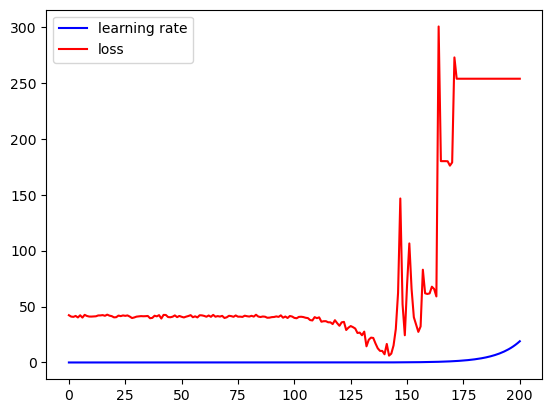

In [56]:
EPOCHS = 10
model = DenseNeuralNet(layer_neurons=[128])

train_step_signature = [
    tf.TensorSpec(shape=(32, 784), dtype=tf.float32),
    tf.TensorSpec(shape=(32, ), dtype=tf.float32)
]


# @tf.function(input_signature=train_step_signature)
def train_step(X, y):
    metrics_dict = model.train_step([X, y])
    loss = metrics_dict["loss"]
    return loss


lr = 1e-7
lrs = []
losses = []

try:
    for epoch in range(EPOCHS):
        start = time.time()
        # Train step
        for step, (X, y) in enumerate(train_set): # X and y are a batch
            loss = train_step(X, y)

            if (lr > 20 or loss > 1000):
                raise Exception("time to plot")
            model.learning_rate = lr
            lrs.append(lr)
            losses.append(loss)
            lr *= 1.1
except:
    plt.plot(lrs, "-b", label="learning rate")
    plt.plot(losses, "-r", label="loss")
    plt.legend(loc="upper left")
    plt.show()
 



In [57]:
# looks like at about 130, the learning rate is best
best_lr = lrs[130]
print(best_lr)

0.024046344822914113


## Model Creation & Training

20.88958041065115
tf.Tensor(253.73209, shape=(), dtype=float32)


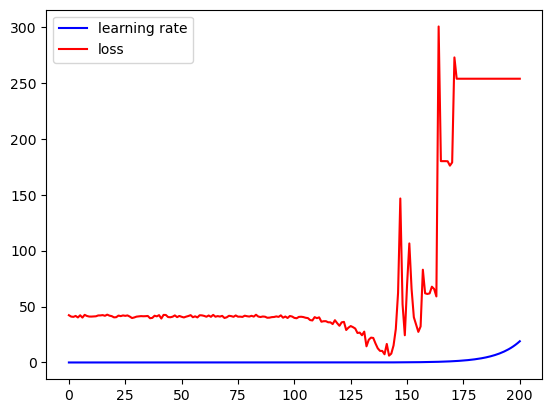

In [53]:

EPOCHS = 10
model = DenseNeuralNet(layer_neurons=[128])
model.learning_rate = best_lr

train_step_signature = [
    tf.TensorSpec(shape=(32, 784), dtype=tf.float32),
    tf.TensorSpec(shape=(32, ), dtype=tf.float32)
]


# @tf.function(input_signature=train_step_signature)
def train_step(X, y):
    metrics_dict = model.train_step([X, y])
    loss = metrics_dict["loss"]
    return loss


for epoch in range(EPOCHS):
    start = time.time()
    # Train step
    for step, (X, y) in enumerate(train_set): # X and y are a batch
        loss = train_step(X, y)

        if step % 200 == 0:
            print(f"Train loss at step {step} is {loss:.4f}")
        
    tf.print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

 

In [39]:
predictions = model.call(test_X[:32])

In [40]:
predictions[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.04442617, 0.01629813, 0.03990909, 0.02080897, 0.02939015,
       0.04171114, 0.02427462, 0.7116272 , 0.01775062, 0.05380385],
      dtype=float32)>

In [42]:
np.argmax(predictions[0])

7

In [43]:
test_y[0]

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [50]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

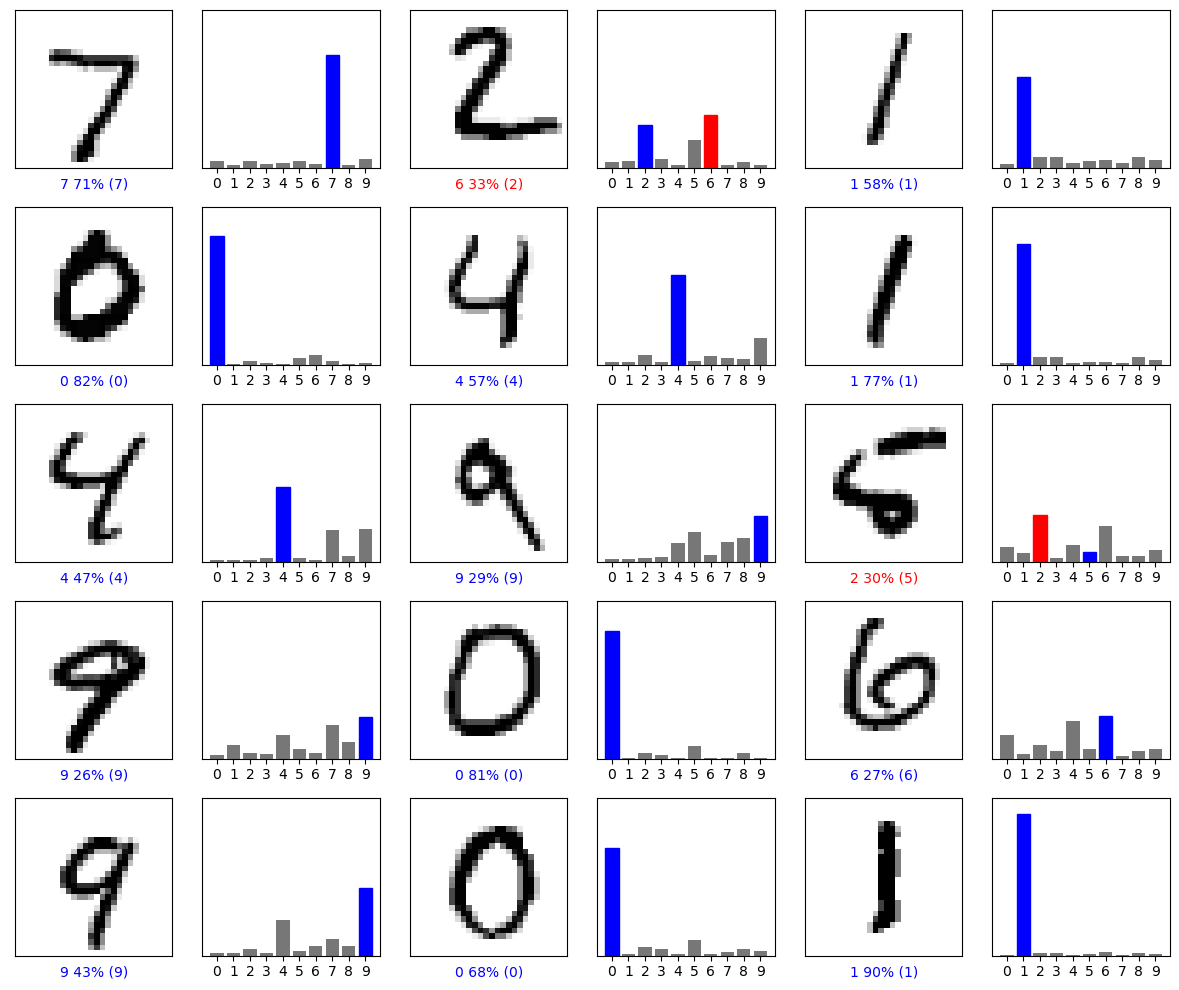

In [51]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
(train_X, train_y), (test_images, test_labels) = mnist.load_data()
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()